# Exploratory Analysis

#### Here you will find some statistics and plots which describe the dataset and give us an idea about how the data behaves 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '../Datasets/speed_dating_cleaner.parquet' #This file is the result of preprocessing
df = pd.read_parquet(path)

There's a group of variables which are of primary interest, namely gender, age, race, the attribute preferences of the subjects and, of course, the response. We target them because those variables were analyzed by Columbia researchers in their 2 papers.

We'll be looking at gender and age distributions first

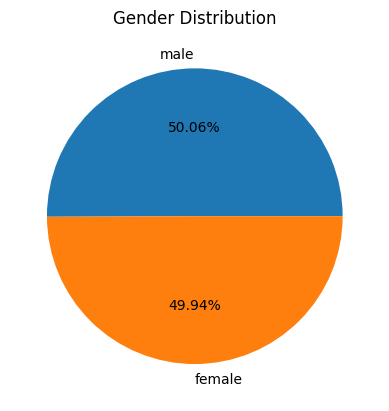

In [3]:
pie_data = df['male'].value_counts()
fig,ax = plt.subplots()
ax.pie(pie_data,labels=['male','female'],autopct='%.2f%%')
ax.set(title='Gender Distribution')
pass

The sample is almost perfectly balanced. However, there is a clear bias in the experiment since only heterosexual subjects participated. If other groups had been included, the distribution could perhaps look different.

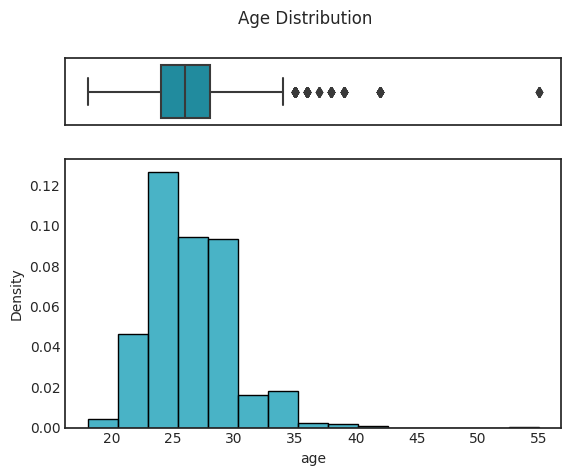

In [4]:
with plt.style.context('seaborn-v0_8-white'):
    fig,axes = plt.subplots(2,gridspec_kw={'height_ratios': (.2, .8)},sharex=True)
    sns.histplot(data=df,x='age',ax=axes[1],bins=15,stat='density',color='#0c9ab3')
    sns.boxplot(data=df,x='age',ax=axes[0],color='#0c9ab3')
    axes[0].get_xaxis().set_visible(False)
    plt.suptitle('Age Distribution') #Unfortunately, some plots will not look like the ones shown on the report. 
    #This is because one of the collaborators worked in R and their code is no longer available.
    pass

Most participants were aged between 20 and 30. Let's calculate the exact number:

In [5]:
len(df.loc[df['age'].between(20,30)])/len(df) #So 88%. For obvious reasons, this distribution is skewed to the right.

0.8870852232036286

Now let's check the race percentages

In [6]:
races = [i for i in df.columns if 'race_' in i and 'o_' not in i]
race_counts = df[races].sum() #But it's encoded using Dummy variables, so there's one category excluded (We'll add it manually)
asian = len(df)-race_counts.sum() #What's needed to top up the df length
race_counts.loc['race_asian'] = asian 
race_counts #Good

race_african_american     420
race_latino               664
race_european            4727
race_other                522
race_asian               2045
dtype: int64

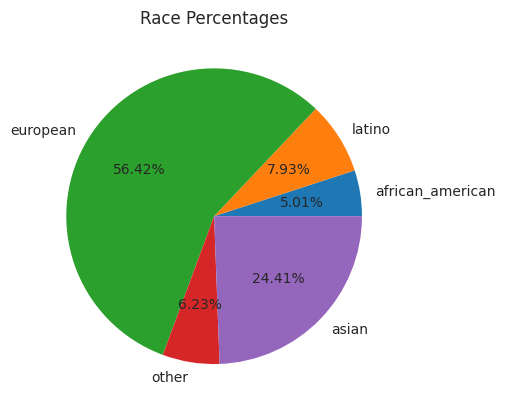

In [7]:
with plt.style.context('seaborn-v0_8-white'):
    labels = [r[5:] for r in race_counts.index]
    plt.pie(race_counts,labels=labels,autopct='%.2f%%')
    plt.title('Race Percentages')

Now, in the articles, the researchers claim that these percentages are in line with the Manhattan population numbers. However, we compared it against the 2010 New York census and found that blacks appear to be underrepresented and asians appear to be overrepresented in this sample. For more information, please refer to [our report](../../Report) 

#### Self-Descriptive Variables

In this section, we inspect the differences between self-rating of attributes and the same attribute ratings by their partners. Going into this section, we expected to see higher self-ratings than peer-ratings.  

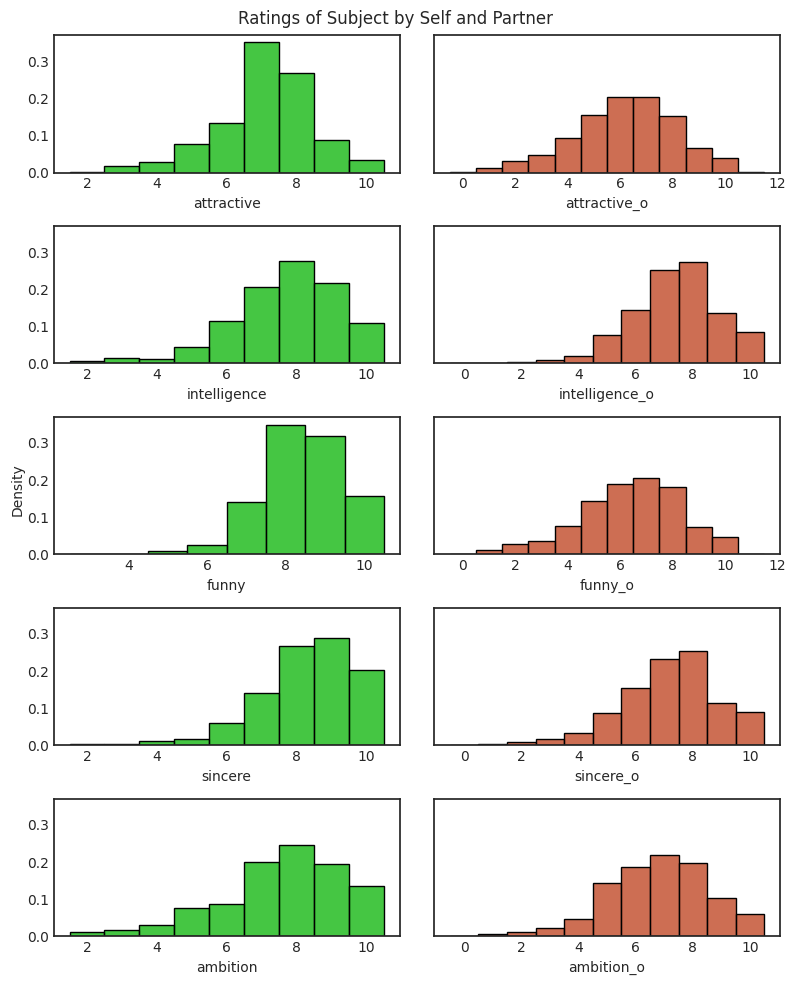

In [8]:
attributes = ['attractive','intelligence','funny','sincere','ambition']
with plt.style.context('seaborn-v0_8-white'):
    fig,axes = plt.subplots(5,2,sharey=True,figsize=(8,10))
    fig.text(0.02, 0.5, 'Density', va='center', rotation='vertical') #We want just 1 ylabel
    fig.suptitle('Ratings of Subject by Self and Partner')
    for n,attribute in enumerate(attributes):
        axes[n,0].set_ylabel(' ')
        axes[n,1].set_ylabel(' ')
        sns.histplot(df,x=attribute,ax=axes[n,0],discrete = True, stat = 'density',color='#06b304')
        if attribute == 'ambition':
            sns.histplot(df,x='ambitious_o',ax=axes[n,1],discrete = True,stat = 'density',color='#bd3e1a')
            axes[n,1].set_xlabel('ambition_o')
        else:
            sns.histplot(df,x=attribute + '_o',ax=axes[n,1],discrete = True,stat = 'density',color='#bd3e1a')
    plt.tight_layout()



The distributions look fairly similar, so we opt to conclude this part of the analysis

#### Influence of Attributes on Decision

Since we want to evaluate how these variables affect the subjects' decisions, we plot the distributions of how the subjects rate their partner  according to each target variable value and see if there are noticeable differences. 

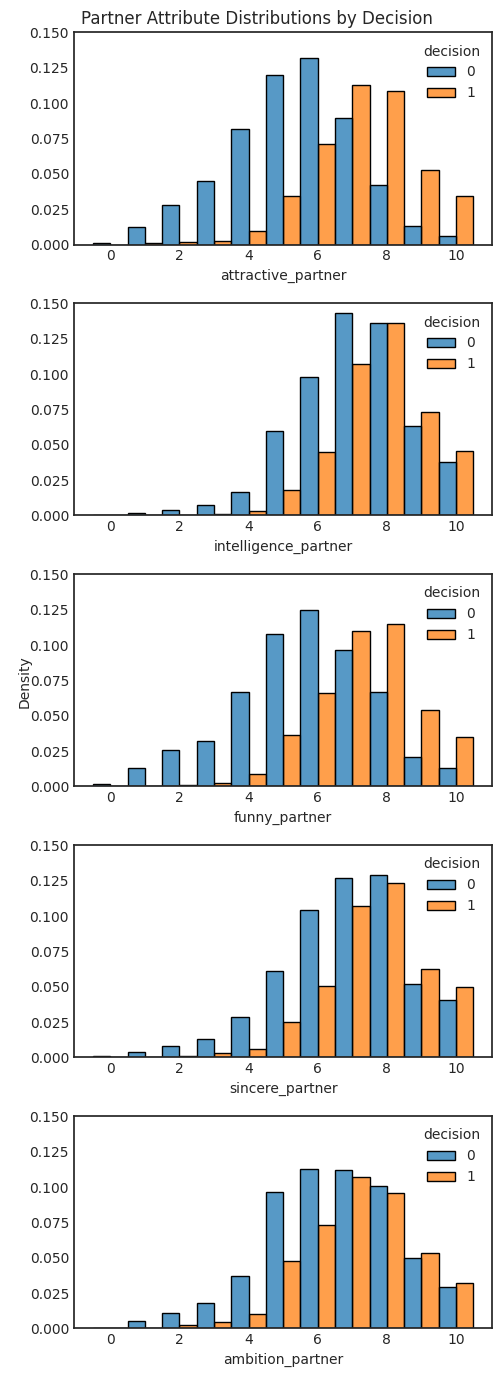

In [9]:
with plt.style.context('seaborn-v0_8-white'):
    fig,axes = plt.subplots(5,1,sharey=True,figsize=(5,14))
    fig.text(0.02, 0.5, 'Density', va='center', rotation='vertical') 
    fig.suptitle('Partner Attribute Distributions by Decision')
    for n,attribute in enumerate(attributes):
        axes[n].set_ylabel(' ')
        sns.histplot(df,x=attribute + '_partner',ax=axes[n],discrete = True, stat = 'density',hue='decision',multiple='dodge')
    plt.tight_layout()

And as expected, subjects who chose to date their partner a second time generally gave them higher ratings in these attributes. Attractiveness and sense of humor seem to be the most polarized attributes. Besides, Fisman et al. (2006) find that women tend to place more emphasys on intelligence, while men tend to focus on attractiveness when choosing a prospective partner. For these reasons, we can look further into these 2 attributes:

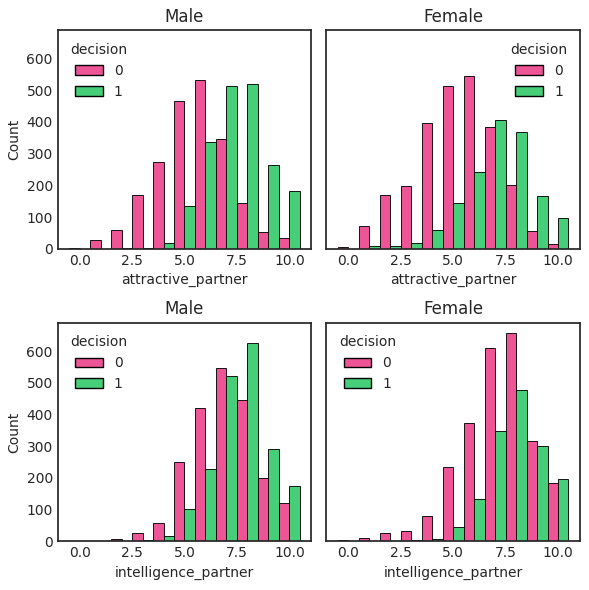

In [10]:
with plt.style.context('seaborn-v0_8-white'):
    fig,axes = plt.subplots(2,2,figsize=(6,6),sharey=True)
    for n,var in enumerate(['attractive_partner','intelligence_partner']):
        sns.histplot(df.loc[df['male'] == 1], x = var,
            hue = 'decision',palette=['#e81c74','#08bf4b'],ax=axes[n,0],multiple='dodge',discrete=True)
        sns.histplot(df.loc[df['male'] == 0], x = var,
            hue = 'decision',palette=['#e81c74','#08bf4b'],ax=axes[n,1],multiple='dodge',discrete=True)
        axes[n,0].set(title='Male')
        axes[n,1].set(title='Female')
    plt.tight_layout()

For attractiveness, the distributions are even more polarized in male subjects. Nevertheless, the differences aren't as clear for the intelligence attribute.

#### Race Influence on Decision

Fisman et al. (2006) find that women tend to have a stronger preference for same-race individuals. We explore this here, but also when we apply machine learning techniques to the data.

In [11]:
#Need extra column for the barplot
df['Gender'] = np.where(df['male'] == 1,'Male','Female')

In [12]:
df.groupby(['Gender','samerace'])['decision'].mean() #To get the y_ coordinates of the vertical lines

Gender  samerace
Female  0           0.347189
        1           0.393245
Male    0           0.473975
        1           0.474668
Name: decision, dtype: float64

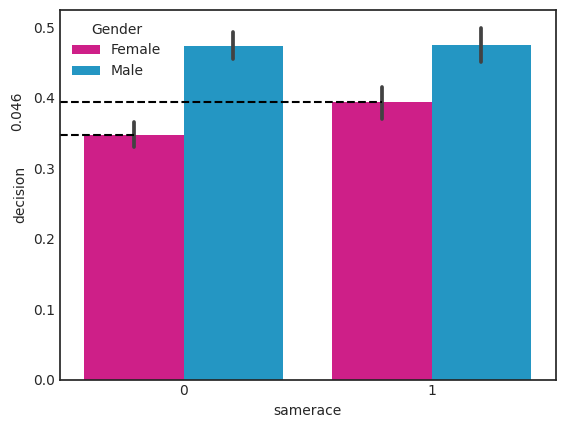

In [13]:
with plt.style.context('seaborn-v0_8-white'):
    sns.barplot(data=df,x='samerace',y='decision',hue = 'Gender',palette=['#eb028e','#09a2de'])
    plt.axhline(y=0.3471, color='black', linestyle='--',xmax=0.15)
    plt.axhline(y=0.3932, color='black', linestyle='--',xmax=0.65)
    plt.annotate(text=f'{np.round(0.393245-0.347189,3)}',xy=(-0.1,0.68),xycoords='axes fraction',**{'rotation':90})

There is a substantial increase in the decision rate (women) when facing individuals of the same race: 0.046 more or 13.2% more. However, we can't be sure of this attribute's importance without comparing it with other features.

In [14]:
preferences = [i for i in df.columns if 'important' in i] #Attribute preference subgroup

#### Correlations

Finally, let's evaluate the partial correlation coefficients between variables and see if we can find something:

In [15]:
numeric = df.select_dtypes(include=['uint8','float','int']) #We'll only analyze numeric columns

In [16]:
num_cols = [col for col in numeric.columns if len(numeric[col].unique()) > 2]


We exclude columns corresponding to subject's partner, since they are "mirror" columns:

In [17]:
num_cols = [i for i in num_cols if '_o' not in i and '_partner' not in i]

In [18]:
num_cols.remove('met') #It contains inconsistent values. Should be 0 and 1 only

In [19]:
#Now we have the columns we want for correlation analysis
numeric = df[num_cols]


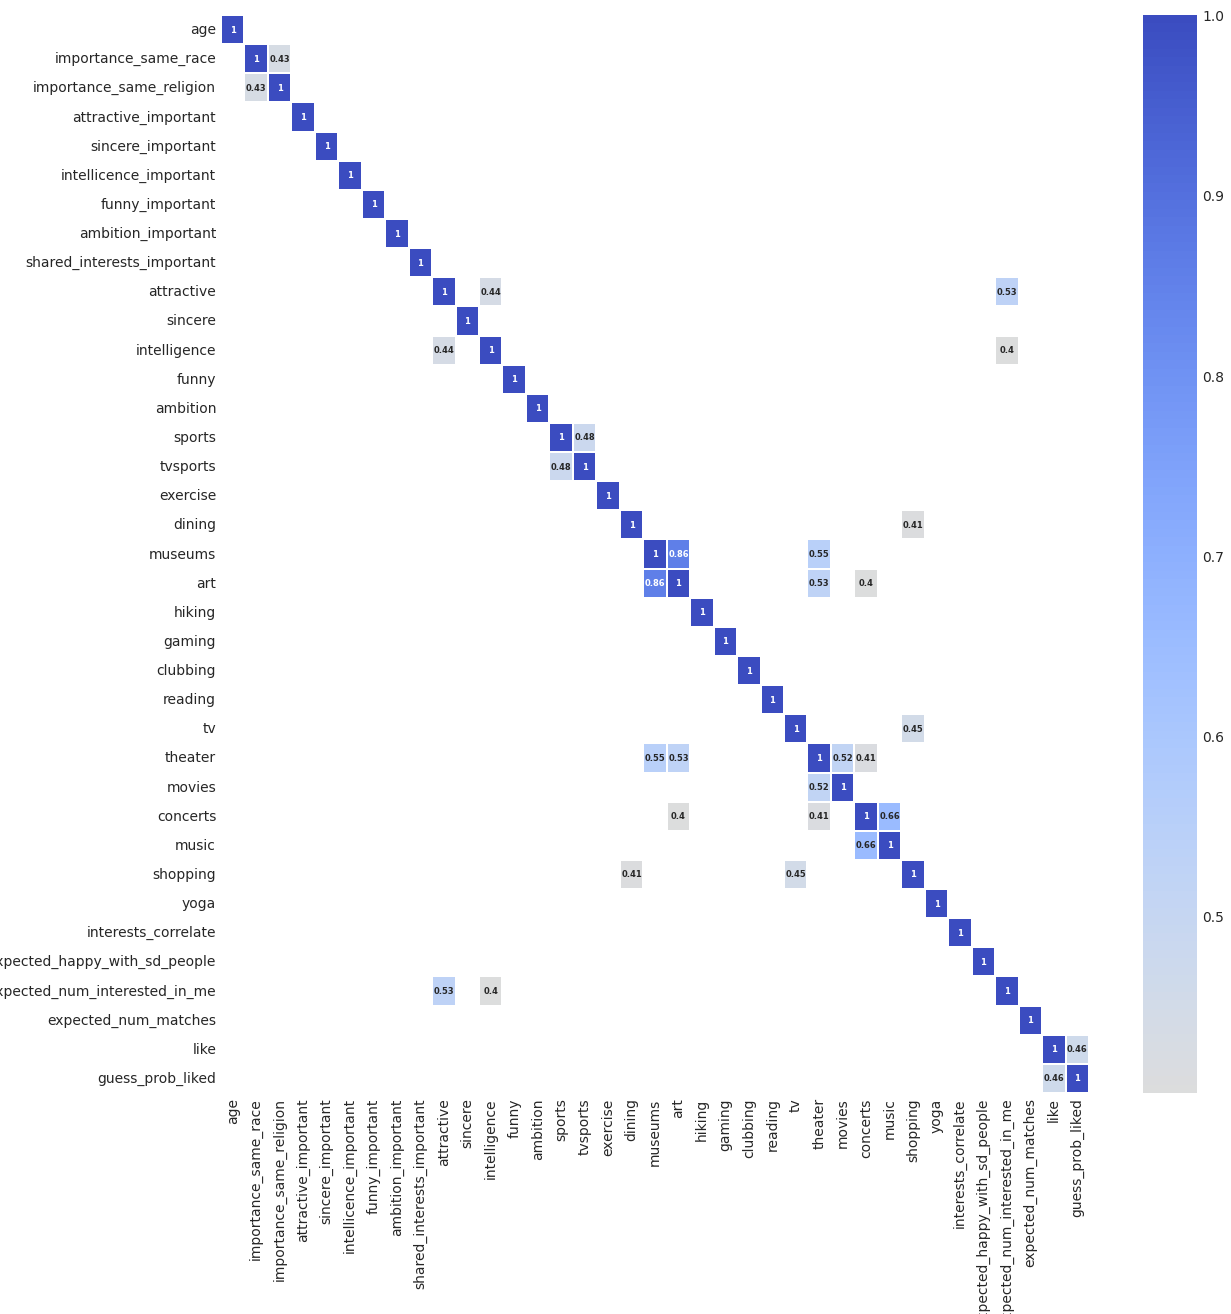

In [20]:
mask = ~(df[num_cols].corr() > 0.4) | (df[num_cols].corr() < -0.4) #To show only big values
#cmap_reversed = matplotlib.cm.get_cmap('autumn_r')
with plt.style.context('seaborn-v0_8-white'):
    fig,ax = plt.subplots(figsize=(14,14))
    sns.heatmap(df[num_cols].corr(),cmap='coolwarm_r',annot=True,linewidth=.3,
        mask=mask,center = 0.4, annot_kws={'size': 6,'fontweight':'bold'})




We are getting different values because this time we're working with the scaled version of the "important" columns (they are scaled in this case)

We would also like to know if any of the columns are highly correlated with the response. And in our case, the response is "decision":

In [21]:
corrs_decision = df[num_cols + ['decision']].corr()['decision']
corrs_decision = corrs_decision.to_frame(name='correlation').copy()

In [22]:
corrs_decision.sort_values(by='correlation',ascending=False).head(5) 

,correlation
decision,1.000000
like,0.513463
guess_prob_liked,0.310861
expected_num_matches,0.229232
expected_num_interested_in_me,0.126247


We do anticipate that "like" (how much subject likes partner) is going to be correlated with their decision. But the next most correlated variables are somewhat surprising. Somehow the subject's level of optimism is related to their number of positive decisions. This is definitely something that could be researched further. 

In [23]:
corrs_decision.sort_values(by='correlation',ascending=False).tail(5) 

,correlation
attractive,-0.046877
exercise,-0.056415
shared_interests_important,-0.059687
importance_same_religion,-0.069210
importance_same_race,-0.092271


They represent "importance" assigned by subject. Unfortunately, there is no information about the subjects' religions. But we do have columns for "samerace" and "interests_correlate":

In [24]:
df[num_cols + ['decision','samerace']].corr()['decision'].loc[['samerace','interests_correlate']]

samerace               0.023036
interests_correlate    0.018517
Name: decision, dtype: float64

And they are close to 0, which could indicate that the subjects' revealed preferences are different from their stated preferences ("important"). However, none of the 4 correlation coefficients (-0.069,-0.092,0.023,0.018) are very different from 0. For the first 2, we could test their statistical significance, but we're going to let the machine learning models tell us if they are important.